In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

%matplotlib inline

In [2]:
import functools
    
def gen_data(dimensions, size, maxval, err_sigma):
    true_b = sps.norm.rvs(size=dimensions + 1)
    X = sps.uniform(-maxval, maxval * 2).rvs(size=(size, dimensions))
    y = X @ true_b[1:] + true_b[0] + sps.norm(scale=err_sigma).rvs(size)
    return true_b, X, y


In [3]:
EPS = 1e-7

def gradient_descent(x, steps, gradient, rate_function):
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    for i in range(steps):
        grad = gradient(x)
        x = x - rate_function(x=x, direction=grad, iteration=i) * grad
        x_values[i + 1] = x
    return x_values

def delayed_gradient_descent(x, steps, gradient, rate_function):
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    previous_grad = np.zeros(shape=(x.size))
    for i in range(steps):
        grad = gradient(x)
        x = x - rate_function(x=x, direction=previous_grad, iteration=i) * previous_grad
        previous_grad = grad
        x_values[i + 1] = x
    return x_values

In [4]:
def AC_SA(x, steps, gradient, L, alpha, prox_map):
    def beta(t):
        return (t + 1) / 2
    
    def gamma(t):
        return (t + 1) / 2 * (alpha / (2 * L))
    
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    x_ag = np.array(x)
    for i in range(steps):
        b = 1 / beta(i + 1)
        
        x_mid = x * b + (1 - b) * x_ag
        grad = gradient(x_mid) * gamma(i + 1)
        
        x = prox_map(x, grad)
        
        x_ag = b * x + (1 - b) * x_ag
        x_values[i + 1] = x
    return x_values

def AC_SA_delayed(x, steps, gradient, L, alpha, prox_map):
    def beta(t):
        return (t + 1) / 2
    
    def gamma(t):
        return (t + 1) / 2 * (alpha / (2 * L))
    
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    x_ag = np.array(x)
    previous_grad = np.zeros(shape=(x.size))
    for i in range(steps):
        b = 1 / beta(i + 1)
        
        x_mid = x * b + (1 - b) * x_ag
        grad = previous_grad * gamma(i + 1)
        previous_grad = gradient(x_mid)
        
        x = prox_map(x, grad)
        
        x_ag = b * x + (1 - b) * x_ag
        x_values[i + 1] = x
    return x_values

def AC_SA_double_delayed(x, steps, gradient, L, alpha, prox_map):
    def beta(t):
        return (t + 1) / 2
    
    def gamma(t):
        return (t + 1) / 2 * (alpha / (2 * L))
    
    x_values = np.zeros(shape=(steps + 1, x.size))
    x_values[0] = x
    x_ag = np.array(x)
    previous_grad = np.zeros(shape=(x.size))
    previous_grad1 = np.zeros(shape=(x.size))
    for i in range(steps):
        b = 1 / beta(i + 1)
        
        x_mid = x * b + (1 - b) * x_ag
        grad = (previous_grad + previous_grad1) / 2
        grad = grad * gamma(i + 1)
        previous_grad1 = previous_grad
        previous_grad = gradient(x_mid)
        
        x = prox_map(x, grad)
        
        x_ag = b * x + (1 - b) * x_ag
        x_values[i + 1] = x
    return x_values

In [5]:
def best_rate_func(function):
    def rate_func(x, direction, **kwargs):
        h = 1
        old_y = function(x)
#         if old_y > function(x - direction):
#             h = -1
        y = function(x - h * direction)
        while old_y > y:
            old_y = y
            h *= 2
            y = function(x - h * direction)
        left = 0
        right = 1
        while left + EPS < right:
            m1 = (left * 2 + right) / 3
            m2 = (left + right * 2) / 3
            if function(x - m1 * h * direction) < function(x - m2 * h * direction):
                right = m2
            else:
                left = m1
        return left * h
    return rate_func

def decaying_rate(koef):
    def rate(iteration, **kwargs):
        return koef / np.sqrt(iteration + 1)
    return rate

def lipschitz_rate(L, koef):
    def rate(**kwargs):
        return L * koef
    return rate

class OLS:
    def __init__(self, X, y):
        Xt = np.insert(X.T, 0, np.ones(X.shape[0])).reshape(-1, X.shape[0])
        self.X = Xt.T
        self.y = y
        
    def gradient(self, b):
        dy = self.X @ b - self.y
        grad = 2 * dy @ self.X
        return grad
    
    def function(self, b):
        dy = self.X @ b - self.y
        return (dy ** 2).sum()
    
    def function_multi(self, B):
        return np.apply_along_axis(self.function, 1, B)
    
    def lipschitz(self):
        return np.abs(self.X.T @ self.X).max()
    
    def experimental_min(self):
        result = gradient_descent(
            np.ones(self.X.shape[1]),
            100000,
            self.gradient,
            lipschitz_rate(1 / self.lipschitz(), 1e-1)
        )
        #result = gradient_descent(np.ones(self.X.shape[1]), 10000, self.gradient, best_rate_func(self.function))
        return self.function(result[-1])
    
    def prox_map(self, x, y):
        return x - y

In [6]:
dims = 3
size = 100
true_b, X, y = gen_data(dims, size, 2, 0.1)
print(true_b)
print(y)

[-0.68912912 -1.47929438  0.62425643 -0.24582682]
[-1.15586803  0.24730168 -3.00883067 -1.41522011 -2.2026425  -3.73834693
  2.37083852 -1.01119028  0.91096857  0.83771928  0.51959378  0.34916927
  0.61482804  0.63880223  0.37540777 -0.42325294  2.31446283 -4.87433004
 -2.08157467 -1.1791135  -2.71441929  0.093275   -1.8701676   0.93383182
 -0.04219458  1.89901737 -1.30906243 -1.44306122 -1.14890142  0.80925587
 -0.76900707 -2.47545307  2.16306988  1.36585341 -0.10110112 -1.98100655
 -1.50740163 -2.26489842 -2.96945535 -2.05195802 -3.10413135  0.50653235
 -1.85207389  1.11191493  0.91684688 -3.85458093  1.25293401 -1.39889977
  0.8096401  -0.73196666 -1.97726442 -1.04315487 -4.01311948 -0.49000433
  0.66778306 -3.56562806 -0.12680523 -0.52092102  0.3062489   0.1764737
  1.70897972 -1.02714729 -2.66814051 -1.3807612  -0.924743   -0.9061879
  1.41213377  1.18640205  2.0957423   1.3712359   0.59552935 -0.88879552
 -0.36963625 -2.13786408 -4.33318689  2.14750615 -1.91539862  2.10589566
 -4

In [7]:
ols = OLS(X, y)
rate = 1 / ols.lipschitz()
print(1/rate)

steps = 100

141.234807864


In [8]:
total_min = ols.experimental_min()
total_min

1.0273151789367003

In [9]:
lipschitz_results = gradient_descent(np.ones(dims + 1), steps, ols.gradient, lipschitz_rate(rate, 1e-1))
print(lipschitz_results[-1])
best_results = gradient_descent(np.ones(dims + 1), steps, ols.gradient, best_rate_func(ols.function))
print(best_results[-1])
decay_results = gradient_descent(np.ones(dims + 1), steps, ols.gradient, decaying_rate(1e-3))
print(decay_results[-1])
print(ols.function(lipschitz_results[-1]))

[-0.69815823 -1.48022268  0.62102526 -0.24772083]
[-0.69815927 -1.48022276  0.62102503 -0.24772101]
[-0.64657636 -1.45924793  0.62220109 -0.22807063]
1.02731517905


In [10]:
delayed_lipschitz_results = delayed_gradient_descent(np.ones(dims + 1), steps, ols.gradient, lipschitz_rate(rate, 1e-1))
print(lipschitz_results[-1])
delayed_best_results = delayed_gradient_descent(np.ones(dims + 1), steps, ols.gradient, best_rate_func(ols.function))
print(best_results[-1])
delayed_decay_results = delayed_gradient_descent(np.ones(dims + 1), steps, ols.gradient, decaying_rate(1e-3))
print(decay_results[-1])

[-0.69815823 -1.48022268  0.62102526 -0.24772083]
[-0.69815927 -1.48022276  0.62102503 -0.24772101]
[-0.64657636 -1.45924793  0.62220109 -0.22807063]


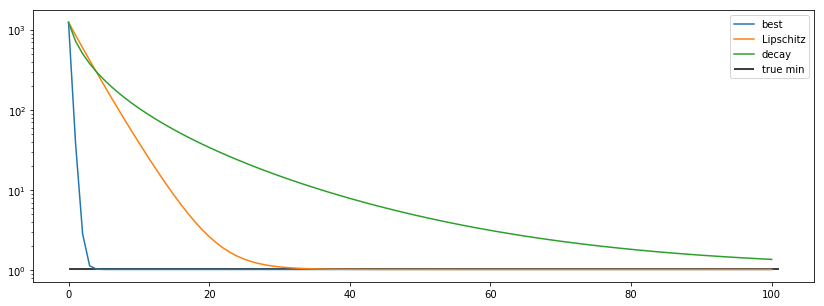

In [11]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(ols.function_multi(best_results), label="best")
plt.plot(ols.function_multi(lipschitz_results), label="Lipschitz")
plt.plot(ols.function_multi(decay_results), label="decay")
plt.hlines([total_min], xmin=0, xmax=best_results.shape[0], label="true min")
plt.legend()
plt.show()

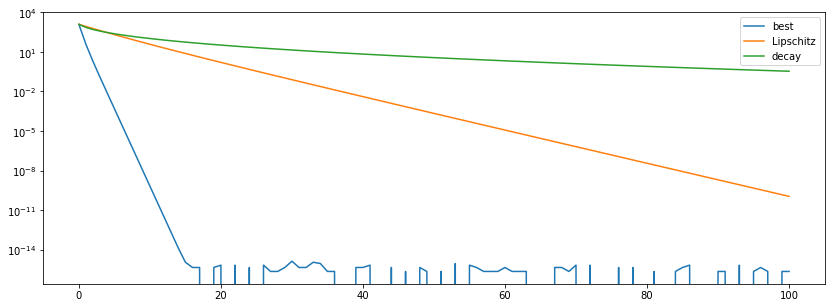

In [12]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(ols.function_multi(best_results) - total_min, label="best")
plt.plot(ols.function_multi(lipschitz_results) - total_min, label="Lipschitz")
plt.plot(ols.function_multi(decay_results) - total_min, label="decay")
plt.legend()
plt.show()

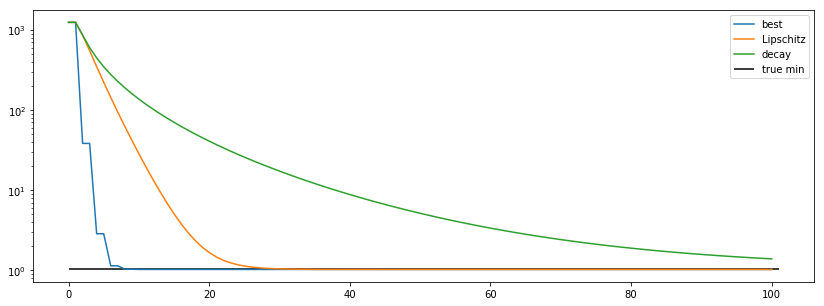

In [13]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(ols.function_multi(delayed_best_results), label="best")
plt.plot(ols.function_multi(delayed_lipschitz_results), label="Lipschitz")
plt.plot(ols.function_multi(delayed_decay_results), label="decay")
plt.hlines([total_min], xmin=0, xmax=best_results.shape[0], label="true min")
plt.legend()
plt.show()

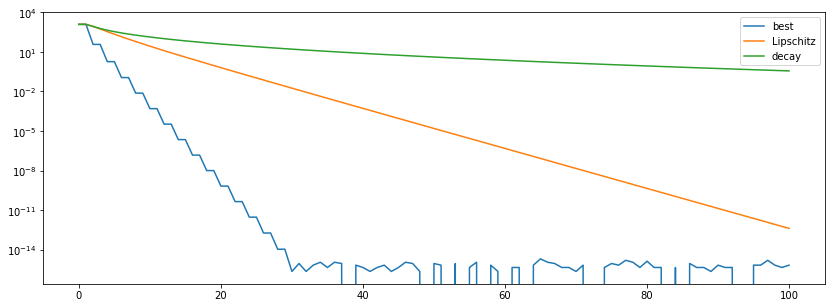

In [14]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(ols.function_multi(delayed_best_results) - total_min, label="best")
plt.plot(ols.function_multi(delayed_lipschitz_results) - total_min, label="Lipschitz")
plt.plot(ols.function_multi(delayed_decay_results) - total_min, label="decay")
plt.legend()
plt.show()

In [15]:
ac_sa_results = AC_SA(np.zeros(dims + 1), steps, ols.gradient, 1/rate, 1, ols.prox_map)
print(ac_sa_results[-1])
delayed_ac_sa_results = AC_SA_delayed(np.zeros(dims + 1), steps, ols.gradient, 1/rate, 1/10, ols.prox_map)
print(delayed_ac_sa_results[-1])
double_delayed_ac_sa_results = AC_SA_double_delayed(np.zeros(dims + 1), steps, ols.gradient, 1/rate, 0.03, ols.prox_map)
print(double_delayed_ac_sa_results[-1])

[-0.69815927 -1.48022276  0.62102503 -0.24772101]
[-0.70938105 -1.5906324   0.60113584 -0.27601456]
[-0.66063848 -1.65614922  0.78339443 -0.6058404 ]


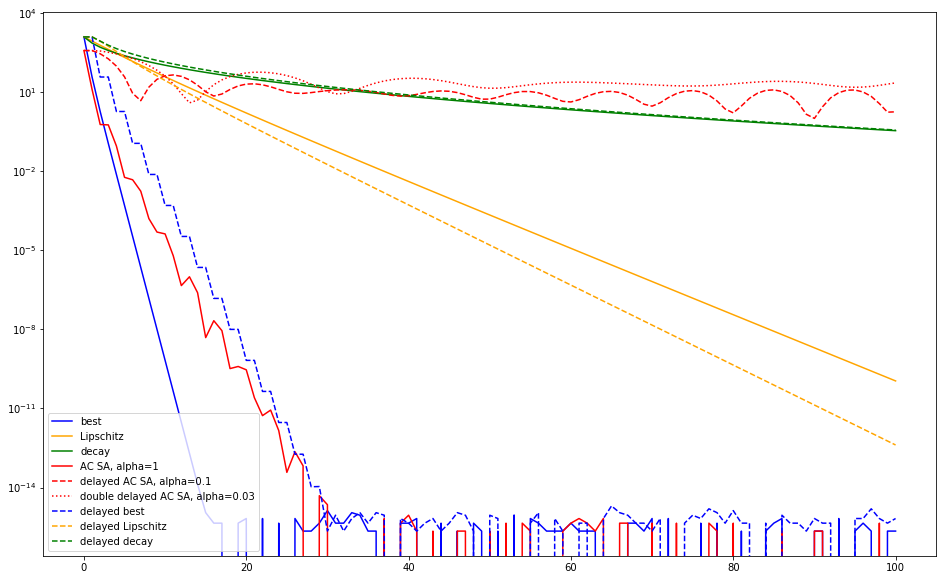

In [16]:
plt.figure(figsize=(16, 10))
plt.yscale("log")

plt.plot(ols.function_multi(best_results) - total_min, label="best", color='blue')
plt.plot(ols.function_multi(lipschitz_results) - total_min, label="Lipschitz", color='orange')
plt.plot(ols.function_multi(decay_results) - total_min, label="decay", color='green')

plt.plot(ols.function_multi(ac_sa_results) - total_min, label='AC SA, alpha=1', color='red')
plt.plot(ols.function_multi(delayed_ac_sa_results) - total_min, label='delayed AC SA, alpha=0.1', color='red', linestyle = '--')
plt.plot(ols.function_multi(double_delayed_ac_sa_results) - total_min, label='double delayed AC SA, alpha=0.03', color='red', linestyle = ':')

plt.plot(ols.function_multi(delayed_best_results) - total_min, label="delayed best", color='blue', linestyle="--")
plt.plot(ols.function_multi(delayed_lipschitz_results) - total_min, label="delayed Lipschitz", color='orange', linestyle="--")
plt.plot(ols.function_multi(delayed_decay_results) - total_min, label="delayed decay", color='green', linestyle="--")

plt.legend()
plt.show()

Для logloss, $y_i \in \{-1, 1\}$:
$$
Q(w) = \sum\limits_{i=1}^{n} \ln(1 + \exp (-y_i \langle x_i, w \rangle))
$$
$$
\frac{d}{dw_j} Q(w) = \sum\limits_{i=1}^{n} x_i^j \frac{-y_i \exp (-y_i \langle x_i, w \rangle)}{1 + \exp (-y_i \langle x_i, w \rangle)}
$$
$$
\frac{d^2}{dw_jdw_k} Q(w) = \sum\limits_{i=1}^{n} x_i^j x_i^k \frac{(y_i)^2 \exp (-y_i \langle x_i, w \rangle)}{(1 + \exp (-y_i \langle x_i, w \rangle))^2} = \sum\limits_{i=1}^{n} x_i^j x_i^k \frac{\exp (-y_i \langle x_i, w \rangle)}{(1 + \exp (-y_i \langle x_i, w \rangle))^2}
$$

In [17]:
class LogReg:
    def __init__(self, X, y):
        Xt = np.insert(X.T, 0, np.ones(X.shape[0])).reshape(-1, X.shape[0])
        self.X = Xt.T
        self.y = y

    def gradient(self, b):
        exp = np.exp(-(self.X @ b) * self.y)
        
        koef =  exp / (1 + exp)
        koef[np.isnan(koef)] = 1
        
        value = -self.y * koef
        grad = value @ self.X
        return grad

    def function(self, b):
        error = -(self.X @ b) * self.y
        exp = np.exp(error)
        result = np.log(1 + exp)
        mask = np.isposinf(result)
        result[mask] = error[mask]
        return result.sum()
    
    def function_multi(self, B):
        return np.apply_along_axis(self.function, 1, B)
    
    def lipschitz(self):
        return 1000
    
    def experimental_min(self):
        result = gradient_descent(
            np.ones(self.X.shape[1]),
            1000000,
            self.gradient,
            lipschitz_rate(1 / self.lipschitz(), 1e-1)
        )
        #result = gradient_descent(np.ones(self.X.shape[1]), 10000, self.gradient, best_rate_func(self.function))
        return self.function(result[-1])
    
    def prox_map(sefl, x, y):
        return x - y

In [18]:
dims = 3
size = 100
true_b, X, y = gen_data(dims, size, 10, 10)

X[size // 2:] += sps.norm.rvs(2, 0.1, size=(dims)) 
y[size // 2:] = 1
y[:size // 2] = -1

# true_y = X @ true_b[1:] + true_b[0]
# mask = true_y >= y
# y[mask] = 1
# y[~mask] = -1

# print(true_b1)
# print(true_b2)
# print(y)
# print(X)

In [19]:
logreg = LogReg(X, y)
steps = 300

In [20]:
%%time

total_min = logreg.experimental_min()
print(total_min)

63.392766861
CPU times: user 9.91 s, sys: 14.7 ms, total: 9.92 s
Wall time: 9.93 s


In [21]:
lipschitz_results = gradient_descent(np.ones(dims + 1), steps, logreg.gradient,
                                     lipschitz_rate(1 / logreg.lipschitz(), 1))
print(lipschitz_results[-1])
best_results = gradient_descent(np.ones(dims + 1), steps, logreg.gradient, best_rate_func(logreg.function))
print(best_results[-1])
decay_results = gradient_descent(np.ones(dims + 1), steps, logreg.gradient, decaying_rate(5e-3))
print(decay_results[-1])

[-0.19284314  0.1015108  -0.00089132  0.0456277 ]


/home/bixind/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


[-0.1958101   0.10162025 -0.00079253  0.04569067]
[-0.15184674  0.100035   -0.00225947  0.04477212]


In [22]:
delayed_lipschitz_results = delayed_gradient_descent(np.ones(dims + 1), steps, logreg.gradient,
                                                     lipschitz_rate(1 / logreg.lipschitz(), 1))
print(lipschitz_results[-1])
delayed_best_results = delayed_gradient_descent(np.ones(dims + 1), steps, logreg.gradient, best_rate_func(logreg.function))
print(best_results[-1])
delayed_decay_results = delayed_gradient_descent(np.ones(dims + 1), steps, logreg.gradient, decaying_rate(5e-3))
print(decay_results[-1])

[-0.19284314  0.1015108  -0.00089132  0.0456277 ]


/home/bixind/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


[-0.1958101   0.10162025 -0.00079253  0.04569067]
[-0.15184674  0.100035   -0.00225947  0.04477212]


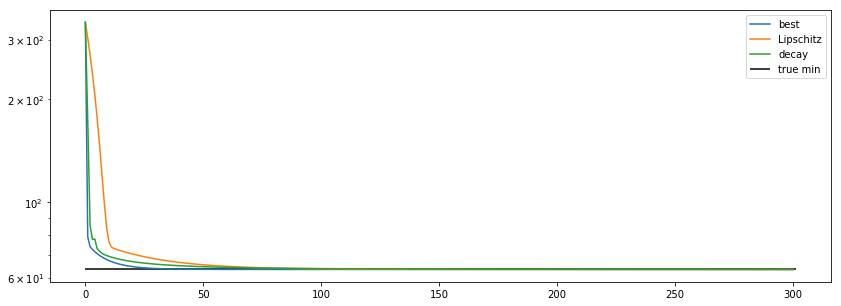

In [23]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(logreg.function_multi(best_results), label="best")
plt.plot(logreg.function_multi(lipschitz_results), label="Lipschitz")
plt.plot(logreg.function_multi(decay_results), label="decay")
plt.hlines([total_min], xmin=0, xmax=best_results.shape[0], label="true min")
plt.legend()
plt.show()

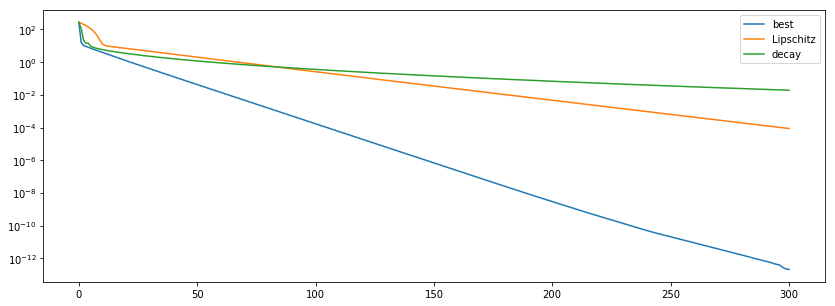

In [24]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(logreg.function_multi(best_results) - total_min, label="best")
plt.plot(logreg.function_multi(lipschitz_results) - total_min, label="Lipschitz")
plt.plot(logreg.function_multi(decay_results) - total_min, label="decay")
plt.legend()
plt.show()

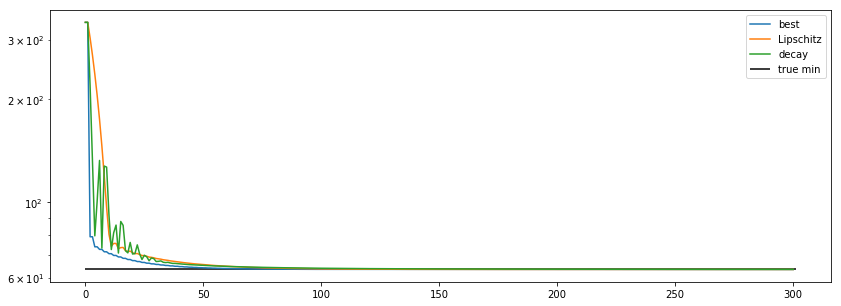

In [25]:

plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(logreg.function_multi(delayed_best_results), label="best")
plt.plot(logreg.function_multi(delayed_lipschitz_results), label="Lipschitz")
plt.plot(logreg.function_multi(delayed_decay_results), label="decay")
plt.hlines([total_min], xmin=0, xmax=best_results.shape[0], label="true min")
plt.legend()
plt.show()

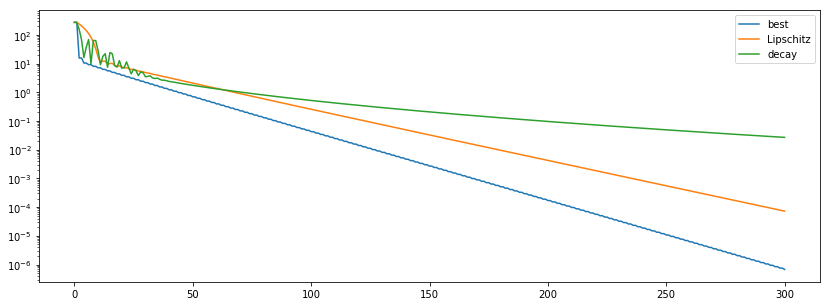

In [26]:
plt.figure(figsize=(14, 5))
plt.yscale("log")
plt.plot(logreg.function_multi(delayed_best_results) - total_min, label="best")
plt.plot(logreg.function_multi(delayed_lipschitz_results) - total_min, label="Lipschitz")
plt.plot(logreg.function_multi(delayed_decay_results) - total_min, label="decay")
plt.legend()
plt.show()

In [57]:
ac_sa_results = AC_SA(np.ones(dims + 1) / (dims + 1), steps, logreg.gradient, logreg.lipschitz(), 1, logreg.prox_map)
print(ac_sa_results[-1])
delayed_ac_sa_results = AC_SA_delayed(np.ones(dims + 1) / (dims + 1), steps, logreg.gradient, logreg.lipschitz(), 1/10, logreg.prox_map)
print(delayed_ac_sa_results[-1])
double_delayed_ac_sa_results = AC_SA_double_delayed(np.ones(dims + 1) / (dims + 1), steps, logreg.gradient, logreg.lipschitz(), 1/10, logreg.prox_map)
print(double_delayed_ac_sa_results[-1])

[-0.20531627  0.10197179 -0.00047606  0.04589275]
[-0.27989241  0.08225234 -0.02807892  0.01627225]
[-0.31444934 -0.20081424 -0.29103743 -0.25908934]


In [59]:
ac_sa_results

array([[ 0.25      ,  0.25      ,  0.25      ,  0.25      ],
       [ 0.24318144,  0.2146743 ,  0.19931806,  0.21060282],
       [ 0.23322773,  0.16595525,  0.13045324,  0.1556951 ],
       ..., 
       [-0.20732668,  0.10204607, -0.00040912,  0.04593546],
       [-0.20636711,  0.10201062, -0.00044107,  0.04591508],
       [-0.20531627,  0.10197179, -0.00047606,  0.04589275]])

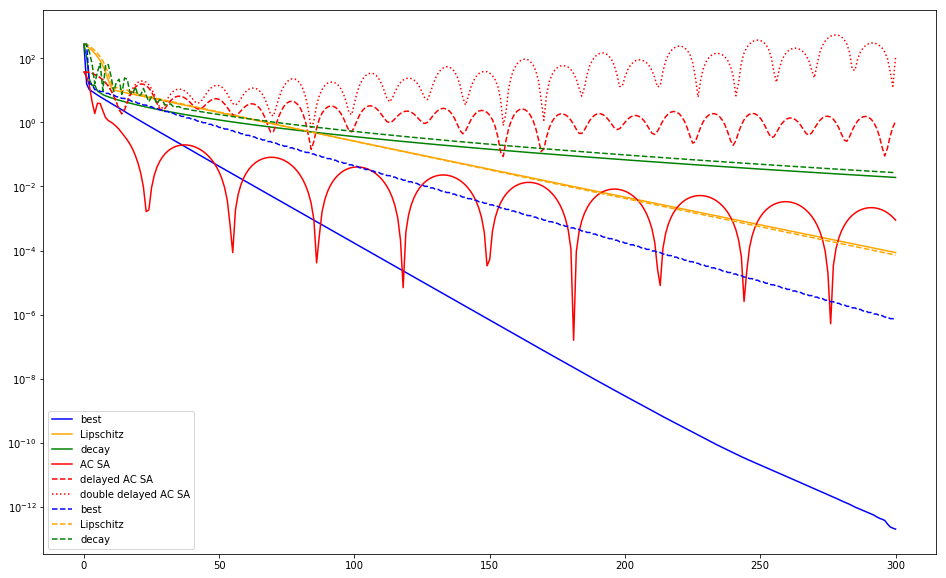

In [58]:
plt.figure(figsize=(16, 10))
plt.yscale("log")

plt.plot(logreg.function_multi(best_results) - total_min, label="best", color='blue')
plt.plot(logreg.function_multi(lipschitz_results) - total_min, label="Lipschitz", color='orange')
plt.plot(logreg.function_multi(decay_results) - total_min, label="decay", color='green')

plt.plot(logreg.function_multi(ac_sa_results) - total_min, label="AC SA", color='red')
plt.plot(logreg.function_multi(delayed_ac_sa_results) - total_min, label="delayed AC SA", color='red',  linestyle="--")
plt.plot(logreg.function_multi(double_delayed_ac_sa_results) - total_min, label="double delayed AC SA", color='red',  linestyle=":")

plt.plot(logreg.function_multi(delayed_best_results) - total_min, label="best", color='blue', linestyle="--")
plt.plot(logreg.function_multi(delayed_lipschitz_results) - total_min, label="Lipschitz", color='orange', linestyle="--")
plt.plot(logreg.function_multi(delayed_decay_results) - total_min, label="decay", color='green', linestyle="--")

plt.legend()
plt.show()